In [ ]:
!pip install -q causal-learn graphviz networkx econml # pygraphviz pyvis
!pip install git+https://github.com/py-why/dowhy@main
!apt-get install graphviz libgraphviz-dev -y
!pip install pygraphviz

In [103]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# step 0 load data
file_path = '/content/drive/My Drive/Colab Notebooks/churn.csv'
data = pd.read_csv(file_path)
data = data.drop(columns=["RowNumber", "Surname", "CustomerId"])
# data = pd.get_dummies(data, columns=["Geography", "Gender"], drop_first=True)
from sklearn.preprocessing import LabelEncoder

data["Geography"] = LabelEncoder().fit_transform(data["Geography"])
data["Gender"] = LabelEncoder().fit_transform(data["Gender"])
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


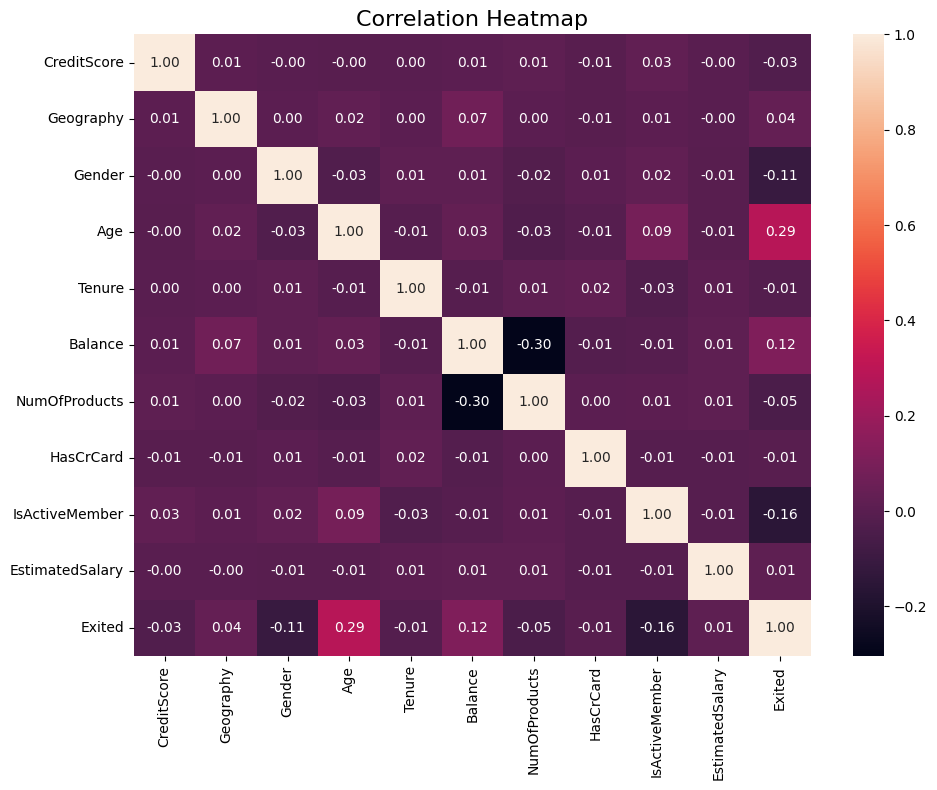

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

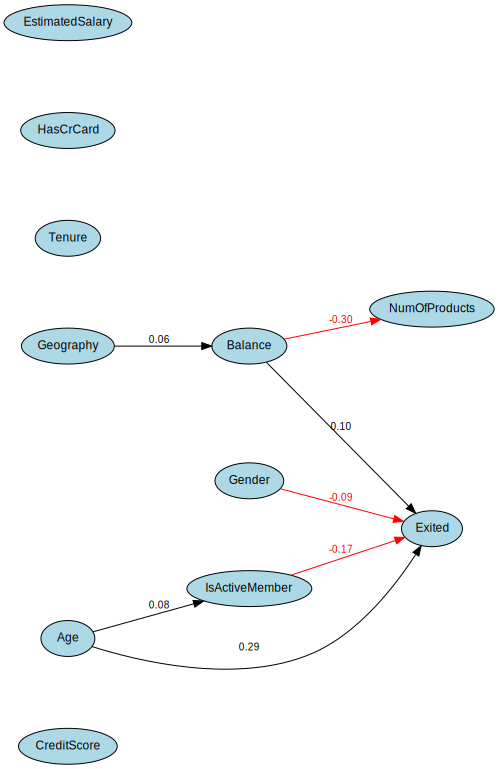

In [47]:
# Step 1: LiNGAM causal discovery
from causallearn.search.FCMBased import lingam
model_lingam = lingam.ICALiNGAM()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

model_lingam.fit(data_scaled.values)
B_hat = model_lingam.adjacency_matrix_

labels = data.columns.tolist()

from graphviz import Source

def pretty_make_dot(adj_matrix, labels):
    dot = ["digraph G {"]
    dot.append('    graph [rankdir=LR, splines=true, overlap=false, nodesep=1.0];')
    dot.append('    node [shape=ellipse, style=filled, fillcolor=lightblue, fontsize=12, fontname=Helvetica];')
    dot.append('    edge [fontsize=10, fontcolor=gray20, fontname=Helvetica];')

    d = adj_matrix.shape[0]
    for i in range(d):
        dot.append(f'    "{labels[i]}" [label="{labels[i]}"];')

    for i in range(d):
        for j in range(d):
            w = adj_matrix[i, j]
            if abs(w) > 1e-8:
                color = "black" if w > 0 else "red"
                dot.append(
                    f'    "{labels[i]}" -> "{labels[j]}" [label="{w:.2f}", color="{color}", fontcolor="{color}"];'
                )

    dot.append("}")
    return Source("\n".join(dot))

pretty_make_dot(B_hat.T, labels)

In [48]:
def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

In [53]:
# Step 3: Create DoWhy CausalModel
graph_dot = make_graph(B_hat, labels=labels)
model = CausalModel(
    data=data,
    treatment="IsActiveMember",
    outcome="Exited",
    graph=str_to_dot(graph_dot.source)
)
# model.view_model()

In [74]:
# Step 3b: Identify causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# pretty print
from IPython.display import Markdown, display

def format_estimand_output(identified_estimand):
    if isinstance(identified_estimand, str):
        display(Markdown("❌ **Error:** This is a string, not an estimand object."))
        return

    display(Markdown(f"### 🎯 Estimand type: `{identified_estimand.estimand_type}`"))
    display(Markdown(f"- **Treatment**: `{identified_estimand.treatment_variable}`"))
    display(Markdown(f"- **Outcome**: `{identified_estimand.outcome_variable}`"))

    for name, est in identified_estimand.estimands.items():
        block = f"#### 🔹 Estimand: `{name}`\n"

        # Skip if est is None
        if est is None:
            block += "- ⚠️ Not available (no valid variables found).\n"
            display(Markdown(block))
            continue

        # Expression
        expr = est.get("estimand", None)
        block += f"- **Expression**: `{expr}`\n" if expr else "- **Expression**: *Not available*\n"

        # Adjustment set
        if "adjustment_set" in est:
            block += f"- **Adjustment set**: `{est['adjustment_set']}`\n"

        # Assumptions
        assumptions = est.get("assumptions", {})
        if assumptions:
            block += "- **Assumptions:**\n"
            for k, v in assumptions.items():
                block += f"  - {k}: {v}\n"
        else:
            block += "- *No assumptions.*\n"

        display(Markdown(block))

# Step 3: display
format_estimand_output(identified_estimand)

### 🎯 Estimand type: `EstimandType.NONPARAMETRIC_ATE`

- **Treatment**: `['IsActiveMember']`

- **Outcome**: `['Exited']`

#### 🔹 Estimand: `backdoor1`
- **Expression**: `Derivative(Expectation(Exited|Gender,NumOfProducts,Balance,Age,Geography), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Gender,NumOfProducts,Balance,Age,Geography,U) = P(Exited|IsActiveMember,Gender,NumOfProducts,Balance,Age,Geography)


#### 🔹 Estimand: `backdoor2`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


#### 🔹 Estimand: `backdoor`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


#### 🔹 Estimand: `iv`
- ⚠️ Not available (no valid variables found).


#### 🔹 Estimand: `frontdoor`
- ⚠️ Not available (no valid variables found).


#### 🔹 Estimand: `general1`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


#### 🔹 Estimand: `general_adjustment`
- **Expression**: `Derivative(Expectation(Exited|Age), [IsActiveMember])`
- **Assumptions:**
  - Unconfoundedness: If U→{IsActiveMember} and U→Exited then P(Exited|IsActiveMember,Age,U) = P(Exited|IsActiveMember,Age)


In [101]:
# Step 4: Estimate ATE using linear regression adjustment
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    confidence_intervals=True,
    test_significance=True# ,
    # method_params={"use_interactions": False}
)

from IPython.display import Markdown, display

def summarize_estimate_output(estimate):
    lines = []
    lines.append("### 📊 **Estimated Average Treatment Effect (ATE)**")

    # Point estimate
    lines.append(f"- **ATE value**: `{estimate.value:.4f}`")

    # Confidence Interval
    ci_low, ci_high = estimate.get_confidence_intervals()
    lines.append(f"- **95% CI**: `({ci_low:.4f}, {ci_high:.4f})`")

    # P-value
    pval = estimate.test_stat_significance()["p_value"]
    lines.append(f"- **p-value**: `{pval[0]:.4f}` {'✅ Significant' if pval[0] < 0.05 else '⚠️ Not significant'}")

    # Model formula
    lines.append("### 🧮 **Regression Formula:**")
    lines.append(f"`{estimate.realized_estimand_expr}`")

    # Conditional effect table (optional preview)
    lines.append("\n### 🧩 **Top 5 Conditional Estimates (by subgroup):**")
    try:
        df = estimate.conditional_estimates
        display(Markdown("\n".join(lines)))
        display(df.head())  # show top 5 CATEs
    except Exception:
        lines.append("*No conditional subgroup effects available.*")
        display(Markdown("\n".join(lines)))

summarize_estimate_output(estimate)

### 📊 **Estimated Average Treatment Effect (ATE)**
- **ATE value**: `-0.1454`
- **95% CI**: `(-0.1598, -0.1300)`
- **p-value**: `0.0000` ✅ Significant
### 🧮 **Regression Formula:**
`b: Exited~IsActiveMember+Age+IsActiveMember*Balance+IsActiveMember*Geography+IsActiveMember*Gender`

### 🧩 **Top 5 Conditional Estimates (by subgroup):**

__categorical__Balance    __categorical__Geography  __categorical__Gender
(-0.001, 73080.908]       (-0.001, 1.0]             (-0.001, 1.0]           -0.185837
                          (1.0, 2.0]                (-0.001, 1.0]           -0.184518
(73080.908, 110138.926]   (-0.001, 1.0]             (-0.001, 1.0]           -0.133314
                          (1.0, 2.0]                (-0.001, 1.0]           -0.135020
(110138.926, 133710.358]  (-0.001, 1.0]             (-0.001, 1.0]           -0.120246
dtype: float64

Model LogisticRegressionCV(cv=3, max_iter=1000) has a non-default cv attribute, which will be ignored
Model LassoCV(cv=3) has a non-default cv attribute, which will be ignored


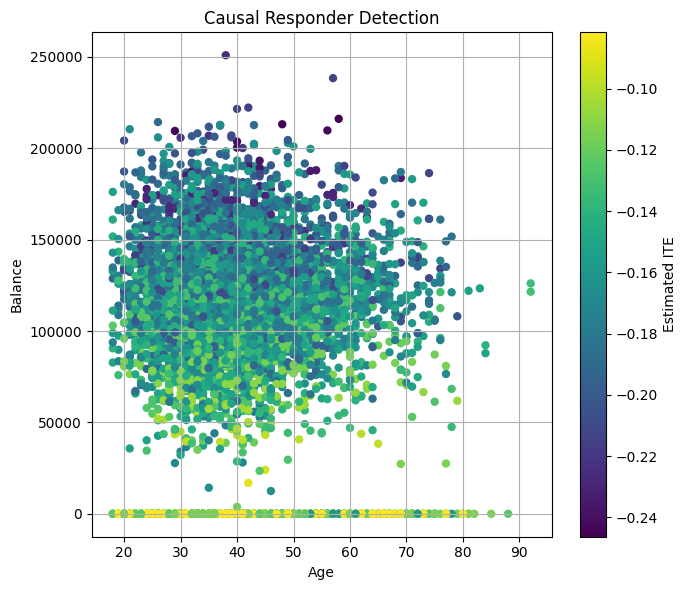

In [122]:
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from econml.dml import LinearDML

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML",
    confidence_intervals=False,
    test_significance=False,
    method_params={
        "init_params": {
            "model_y": LassoCV(cv=3),
            "model_t": LogisticRegressionCV(cv=3, max_iter=1000),
            "discrete_treatment": True,
            "random_state": 0
        },
        "fit_params": {},
        "need_conditional_estimates": True
    }
)

# Individual-level ITE
ite = estimate.estimator.effect(data)

# 2-D scatter (Age vs Balance, color = ITE)
plt.figure(figsize=(7, 6))
sc = plt.scatter(data["Age"], data["Balance"], c=ite, cmap="viridis", s=25)
plt.colorbar(sc, label="Effect Size")
plt.xlabel("Age")
plt.ylabel("Balance")
plt.title("Causal Responder Detection")
plt.grid(True)
plt.tight_layout()
plt.show()


In [102]:
refute = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause",
    simulation_method="e-value",  # this triggers the E-value plot
    num_points_per_contour=200,
    plot_size=(6.4, 4.8),
    contour_colors=["blue", "red"],
    xy_limit=None  # or set manually like (10, 10)
)

NotImplementedError: The current implementation does not support effect modifiers